In [1]:
import time
import sys
from pathlib import Path
import os

import torch
from torch.utils.data import DataLoader

sys.path.append(str(Path().resolve().parent))

In [ ]:
from datamodule.dataset import ImageCSVDataset, TransformSubset
from datamodule.splitter import KFoldSplit
from datamodule.transforms import get_train_transforms, get_val_transforms
from training.balancing import WeightedLossBalancing
from training.trainer import ModelTrainer
from utils.model import get_model
from utils.optimizer import get_optimizer
from configs.config import TrainingConfig
from datamodule.transforms import CenterCrop

CLASS_WEIGHTS = {0: 0.5744292237442923, 1: 0.42557077625570777}
DATASET_MEAN = 0.37203550954887965
DATASET_STD = 0.21801310757916936

# CenterCropping the Validation Set
The results of not center cropping the validation set are shown below. The images that aren't square size already get distorted when resizing to 224x224 pixels. Center cropping the validation set will ensure that all images are square and maintain their aspect ratio.

(552, 341)
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


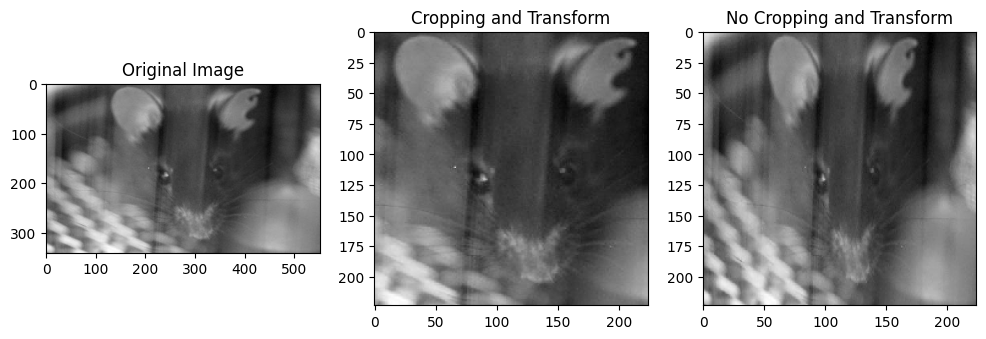

In [3]:
import pandas as pd
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

def find_actual_image_path(img_dir, filename):
    """
    Versucht, die tatsächliche Bilddatei zu finden, indem verschiedene Dateiendungen ausprobiert werden.
    """
    suffixes = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for suffix in suffixes:
        filename = Path(filename).stem + suffix 
        path = img_dir / filename
        if path.exists():
            return path
    return None

df = pd.read_csv(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\labels\labels.csv")
img_dir = Path(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\data")
image_paths = []

for filename in df["filename"]:
    actual_image_name = find_actual_image_path(img_dir, filename)
    image_paths.append(actual_image_name)

for path in image_paths:
    transform_val = get_val_transforms(mean=DATASET_MEAN, std=DATASET_STD)
    transform_test = T.Compose([
        # CenterCrop(),  # Center crop to 224x224
        T.Resize((224, 224), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
        T.Normalize(mean=[DATASET_MEAN], std=[DATASET_STD])
    ])
    img = Image.open(path).convert("L")  # Convert to grayscale
    img_tensor = T.ToTensor()(img)  # Convert to tensor
    val_img = transform_val(img)  # Apply the transformation
    test_img = transform_test(img)  # Apply the test transformation

    if img.size[0] == img.size[1]:
        continue
    
    print(img.size)
    print(val_img.shape)
    print(test_img.shape)
    

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_tensor.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(val_img.squeeze(), cmap='gray')
    plt.title("Cropping and Transform")
    plt.subplot(1, 3, 3)
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.title("No Cropping and Transform")
    plt.show()

    break


# Calculate the mean and standard deviation of the reduced dataset (no wrong our unsufficient labels)
The mean and standard deviation of the reduced dataset can be calculated using the following code snippet. It is visible that their are minor changes compared to the original dataset.

In [14]:
# Calculate the mean and std of of the dataset
import pandas as pd
import os
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import numpy as np

def find_actual_image_path(img_dir, filename):
    """
    Versucht, die tatsächliche Bilddatei zu finden, indem verschiedene Dateiendungen ausprobiert werden.
    """
    suffixes = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for suffix in suffixes:
        filename = Path(filename).stem + suffix 
        path = img_dir / filename
        if path.exists():
            return path
    return None

df = pd.read_csv(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\labels\labels.csv")
img_dir = Path(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\data")
image_paths = []

sum_value = 0
sum_squared = 0
count = 0
for filename in df["filename"]:
    actual_image_name = find_actual_image_path(img_dir, filename)
    img = Image.open(actual_image_name).convert("L")  # Convert to grayscale
    img_tensor = T.ToTensor()(img)  # Convert to tensor
    
    sum_value += img_tensor.sum().item()
    sum_squared += (img_tensor ** 2).sum().item()
    count += img_tensor.numel()

mean_value = sum_value / count
std_value = np.sqrt(sum_squared / count - mean_value ** 2)
print(f"Mean_reduced: {mean_value}, Std_reduced: {std_value}")

sum_value = 0
sum_squared = 0
count = 0
for img_path in os.listdir(img_dir):
    if img_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
        img = Image.open(img_dir / img_path).convert("L")  # Convert to grayscale
        img_tensor = T.ToTensor()(img)
        
        sum_value += img_tensor.sum().item()
        sum_squared += (img_tensor ** 2).sum().item()
        count += img_tensor.numel()

print(len(os.listdir(img_dir)))
mean_value = sum_value / count
std_value = np.sqrt(sum_squared / count - mean_value ** 2)
print(f"Mean_full: {mean_value}, Std_full: {std_value}")

Mean_reduced: 0.37203550954887965, Std_reduced: 0.21801310757916936
3406
Mean_full: 0.3649688627440408, Std_full: 0.23890424112037323


# Classweight Calculation (of the reduced dataset)

In [8]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\labels\labels.csv")
class_counts = df['label'].value_counts()
class_distribution = class_counts / class_counts.sum()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
label
0    0.574429
1    0.425571
Name: count, dtype: float64


# Speed of the pipeline


In [10]:
class_weights = {k: 1 / v for k, v in CLASS_WEIGHTS.items()}  # Invert weights for CrossEntropyLoss
class_weights = {k: v / sum(class_weights.values()) for k, v in class_weights.items()} 
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
    
data_dir = Path(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data")
kfold = KFoldSplit(5, seed=42)
transforms = {
    "train": get_train_transforms(mean=DATASET_MEAN, std=DATASET_STD),
    "val": get_val_transforms(mean=DATASET_MEAN, std=DATASET_STD)
}

trainer_config = TrainingConfig(
    model_builder=get_model,
    optimizer_builder=get_optimizer,
    fold_seeds=[42, 43, 44, 45, 46],  # seed for each cross-validation fold
    shuffle=True,
    early_stopping=True,
    patience=30,
    main_metric="loss",
    balancing_strategy="weighted_loss",
    class_weights=class_weights,  # darf nicht None sein, wenn balancing_strategy != "no_balancing"
    device="cuda" if torch.cuda.is_available() else "cpu"
).to_dict()

config = {
    "batch_size": batch_size,
    "shuffle": True
}

dataset = ImageCSVDataset(data_dir=data_dir)
splits = kfold.get_splits(dataset)
train_indices, val_indices = splits[0]
train_subset = TransformSubset(dataset, train_indices, transforms["train"])
val_subset = TransformSubset(dataset, val_indices, transforms["val"])

loader, criterion = WeightedLossBalancing(class_weights).prepare(train_subset, config, device=device)


Deleted 0 missing images from labels.


## Test the speed of the trainig and evaluation steps

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def profile_train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    time_dl, time_forward, time_loss, time_backward, time_step = 0, 0, 0, 0, 0

    for inputs, labels in train_loader:
        t0 = time.perf_counter()
        inputs, labels = inputs.to(device), labels.to(device)
        t1 = time.perf_counter()

        optimizer.zero_grad()

        t2 = time.perf_counter()
        outputs = model(inputs)
        t3 = time.perf_counter()

        loss = criterion(outputs, labels)
        t4 = time.perf_counter()

        loss.backward()
        t5 = time.perf_counter()

        optimizer.step()
        t6 = time.perf_counter()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        time_dl += t1 - t0
        time_forward += t3 - t2
        time_loss += t4 - t3
        time_backward += t5 - t4
        time_step += t6 - t5

    avg_loss = total_loss / len(train_loader)
    return {
        "loss": avg_loss,
        "acc": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted'),
        "timing": {
            "dataloader": time_dl,
            "forward": time_forward,
            "loss": time_loss,
            "backward": time_backward,
            "step": time_step,
            "total": time_dl + time_forward + time_loss + time_backward + time_step
        }
    }

def profile_validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    time_dl, time_forward, time_loss = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            t0 = time.perf_counter()
            inputs, labels = inputs.to(device), labels.to(device)
            t1 = time.perf_counter()

            outputs = model(inputs)
            t2 = time.perf_counter()

            loss = criterion(outputs, labels)
            t3 = time.perf_counter()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            time_dl += t1 - t0
            time_forward += t2 - t1
            time_loss += t3 - t2

    avg_loss = total_loss / len(val_loader)
    return {
        "loss": avg_loss,
        "acc": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average='weighted'),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted'),
        "timing": {
            "dataloader": time_dl,
            "forward": time_forward,
            "loss": time_loss,
            "total": time_dl + time_forward + time_loss
        }
    }


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(config = {"model_name": "resnet18", "num_classes": 2, "pretrained": False})
model.to(device)
optimizer = get_optimizer(model, config={"optim": "Adam", "learning_rate": 0.001})
train_times, val_times = [], []

for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")

    start_train = time.perf_counter()
    train_result = profile_train_one_epoch(
        model=model,
        train_loader=loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    time_train = time.perf_counter() - start_train
    train_times.append(time_train)

    print(f"Train ⏱️ Total: {time_train:.2f}s | Breakdown:")
    for k, v in train_result["timing"].items():
        print(f"  {k:>10}: {v:.4f}s")

    start_val = time.perf_counter()
    val_result = profile_validate_one_epoch(
        model=model,
        val_loader=DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False),
        criterion=criterion,
        device=device
    )
    time_val = time.perf_counter() - start_val
    val_times.append(time_val)

    print(f"Val   ⏱️ Total: {time_val:.2f}s | Breakdown:")
    for k, v in val_result["timing"].items():
        print(f"  {k:>10}: {v:.4f}s")

    print("-" * 50)

Epoch 1/10
Train ⏱️ Total: 22.93s | Breakdown:
  dataloader: 0.1142s
     forward: 0.3566s
        loss: 0.0172s
    backward: 0.3039s
        step: 0.1620s
       total: 0.9540s
Val   ⏱️ Total: 3.99s | Breakdown:
  dataloader: 0.0288s
     forward: 0.0558s
        loss: 0.0009s
       total: 0.0855s
--------------------------------------------------
Epoch 2/10
Train ⏱️ Total: 22.95s | Breakdown:
  dataloader: 0.1149s
     forward: 0.1775s
        loss: 0.0067s
    backward: 0.2062s
        step: 0.0643s
       total: 0.5695s
Val   ⏱️ Total: 4.09s | Breakdown:
  dataloader: 0.0291s
     forward: 0.0335s
        loss: 0.0009s
       total: 0.0636s
--------------------------------------------------
Epoch 3/10
Train ⏱️ Total: 22.21s | Breakdown:
  dataloader: 0.1113s
     forward: 0.1759s
        loss: 0.0066s
    backward: 0.2005s
        step: 0.0646s
       total: 0.5588s
Val   ⏱️ Total: 3.81s | Breakdown:
  dataloader: 0.0279s
     forward: 0.0330s
        loss: 0.0009s
       total: 

## Check the speed of loading and transforming the data 
The loader itself is the bottleneck of the pipeline. From ca. 22 seconds for each training epoch it take only 0.5 seconds to put the data to gpu, calculate the forward pass, the loss and the backward pass. The rest of the time is spent on loading the data and transforming it. The loading itself takes about 12 seconds (training) and 2 seconds (validation) of the total 15 bzw. 3 seconds needed for the dataloader. The transformation takes about 4 seconds (training) and 0.4 second (validation). Therefore the most time is spent loading the images from disk. Transforming also takes time but is not the bottleneck of the pipeline.

In [12]:
dataloader = DataLoader(train_subset, batch_size = batch_size, shuffle=True, num_workers=0)
start = time.perf_counter()
for x, y in loader:
    _ = x.sum()
duration_iterate = time.perf_counter() - start
print(f"🔹 Iteration über DataLoader dauerte: {duration_iterate:.4f}s")

🔹 Iteration über DataLoader dauerte: 15.6660s


In [13]:
from torch.utils.data import Dataset

class TransformSubset1(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
        
        self.timing = {
            "load_data": [],
            "transform": []
        }

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_load = time.perf_counter()
        img, label = self.base_dataset[self.indices[idx]]
        end_load = time.perf_counter()
        self.timing["load_data"].append(end_load - start_load)
        
        start_transform = time.perf_counter()
        if self.transform:
            img = self.transform(img)
        end_transform = time.perf_counter()
        self.timing["transform"].append(end_transform - start_transform)
        return img, label

transform_train_subset = TransformSubset1(dataset, train_indices, transforms["train"])
transform_val_subset = TransformSubset1(dataset, val_indices, transforms["val"])
train_dataloader = DataLoader(transform_train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(transform_val_subset, batch_size=batch_size, shuffle=False)

# Train loader_time profiling
start = time.perf_counter()
for x, y in train_dataloader:
    _ = x.sum()  # Dummy operation to trigger the DataLoader
duration_train_loader = time.perf_counter() - start
print(f"🔹 Iteration über TransformSubset DataLoader dauerte: {duration_train_loader:.4f}s")

loading_time = sum(transform_train_subset.timing["load_data"]) / len(transform_train_subset.timing["load_data"]) if transform_train_subset.timing["load_data"] else 0
transform_time = sum(transform_train_subset.timing["transform"]) / len(transform_train_subset.timing["transform"]) if transform_train_subset.timing["transform"] else 0
print(f"🔹 Durchschnittliche Ladezeit pro Element: {loading_time:.4f}s")
print(f"🔹 Durchschnittliche Transformationszeit pro Element: {transform_time:.4f}s")
print(f"🔹 Gesamtdauer Ladezeit: {sum(transform_train_subset.timing['load_data'])}")
print(f"🔹 Gesamtdauer Transformationszeit: {sum(transform_train_subset.timing['transform'])}")

# Validation loader_time profiling
start = time.perf_counter() 
for x, y in val_dataloader:
    _ = x.sum()  # Dummy operation to trigger the DataLoader
duration_iterate_transform_subset = time.perf_counter() - start
print(f"🔹 Iteration über TransformSubset DataLoader dauerte: {duration_iterate_transform_subset:.4f}s")

load_data_time = sum(transform_val_subset.timing["load_data"]) / len(transform_val_subset.timing["load_data"]) if transform_val_subset.timing["load_data"] else 0
transform_time = sum(transform_val_subset.timing["transform"]) / len(transform_val_subset.timing["transform"]) if transform_val_subset.timing["transform"] else 0
print(f"🔹 Durchschnittliche Ladezeit pro Element: {load_data_time:.4f}s")
print(f"🔹 Durchschnittliche Transformationszeit pro Element: {transform_time:.4f}s")
print(f"🔹 Gesamtdauer Ladezeit: {sum(transform_val_subset.timing["load_data"])}")
print(f"🔹 Gesamtdauer Transformationszeit: {sum(transform_val_subset.timing["transform"])}")

🔹 Iteration über TransformSubset DataLoader dauerte: 15.6509s
🔹 Durchschnittliche Ladezeit pro Element: 0.0045s
🔹 Durchschnittliche Transformationszeit pro Element: 0.0014s
🔹 Gesamtdauer Ladezeit: 11.869089602027088
🔹 Gesamtdauer Transformationszeit: 3.626266598701477
🔹 Iteration über TransformSubset DataLoader dauerte: 3.4026s
🔹 Durchschnittliche Ladezeit pro Element: 0.0045s
🔹 Durchschnittliche Transformationszeit pro Element: 0.0006s
🔹 Gesamtdauer Ladezeit: 2.95100370189175
🔹 Gesamtdauer Transformationszeit: 0.41405090084299445
